##**Woodwork Machine Optimization Model**
Sebastian, Bradley, Braden

#Imports & Data

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb ...
Unpacking coinor-libcgl1 (0.60.3+repack1-2) ...
Selecting previously unselecte

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyomo.environ import *
from pyomo.gdp import *

In [ ]:
project_lst = {
#Project 1 "Pipe"
    ('Pipe', 'Planer') : {'length': 20, 'after': None},
    ('Pipe','Tablesaw') : {'length': 10, 'after': ('Pipe', 'Planer')},
    ('Pipe','Bandsaw') : {'length': 25, 'after': ('Pipe','Tablesaw')},
    ('Pipe','Lathe') : {'length': 40, 'after': ('Pipe','Bandsaw')},
    ('Pipe','DrillPress') : {'length': 10, 'after': ('Pipe','Lathe')},
    ('Pipe','Sander') : {'length': 50, 'after': ('Pipe','DrillPress')},
    ('Pipe','Assembly')   : {'length': 20, 'after': ('Pipe','Sander')},

#Project 2 "JewelryBox"
    ('JewelryBox','Planer') : {'length': 20, 'after': None},
    ('JewelryBox','Tablesaw') : {'length': 40, 'after': ('JewelryBox','Planer')},
    ('JewelryBox','RouterTable') : {'length': 60, 'after' : ('JewelryBox', 'Tablesaw')},
    ('JewelryBox','Assembly') : {'length': 60, 'after': ('JewelryBox','RouterTable')},
    ('JewelryBox','Sander') : {'length': 30, 'after': ('JewelryBox','Assembly')},

#Project 3 "Pen"
    ('Pen','Bandsaw') : {'length': 15, 'after': None},
    ('Pen','Lathe') : {'length': 60, 'after': ('Pen','Bandsaw')},
    ('Pen','Assembly') : {'length': 30, 'after': ('Pen','Lathe')},  

#Project 4 "Chair"
    ('Chair','Planer') : {'length': 40, 'after': None},
    ('Chair', 'Tablesaw') : {'length': 120, 'after': ('Chair','Planer')},
    ('Chair', 'Bandsaw') : {'length': 60, 'after': ('Chair','Tablesaw')},
    ('Chair', 'Lathe') : {'length' : 90, 'after': ('Chair', 'Bandsaw')},
    ('Chair', 'RouterTable') : {'length': 60, 'after': ('Chair', 'Lathe')},
    ('Chair', 'Sander') : {'length': 90, 'after': ('Chair','RouterTable')},
    ('Chair', 'Assembly')   : {'length': 150, 'after': ('Chair','Sander')},

#Project 5 "Bench"
    ('Bench', 'Planer') : {'length': 40, 'after': None},
    ('Bench','Tablesaw') : {'length': 60, 'after': ('Bench', 'Planer')},
    ('Bench', 'Sander') : {'length': 60, 'after': ('Bench','Tablesaw')},
    ('Bench', 'Assembly')   : {'length': 105, 'after': ('Bench','Sander')},

#Project 6 "Nightstand"
    ('Nightstand', 'Planer') : {'length': 40, 'after': None},
    ('Nightstand', 'Tablesaw') : {'length': 60, 'after': ('Nightstand', 'Planer')},
    ('Nightstand', 'RouterTable') : {'length': 60, 'after': ('Nightstand', 'Tablesaw')},
    ('Nightstand', 'Sander') : {'length': 60, 'after': ('Nightstand','RouterTable')},
    ('Nightstand', 'Assembly')   : {'length': 120, 'after': ('Nightstand','Sander')},

#Project 7 "Table"
    ('Table', 'Planer') : {'length': 40, 'after': None},
    ('Table', 'Tablesaw') : {'length': 60, 'after': ('Table', 'Planer')},
    ('Table', 'RouterTable') : {'length': 60, 'after': ('Table', 'Tablesaw')},
    ('Table', 'Sander') : {'length': 60, 'after': ('Table','RouterTable')},
    ('Table', 'Assembly')   : {'length': 105, 'after': ('Table','Sander')},

#Project 8 "Plaque"
    ('Plaque', 'Planer') : {'length': 20, 'after': None},
    ('Plaque', 'Tablesaw') : {'length': 15, 'after': ('Plaque', 'Planer')},
    ('Plaque', 'Bandsaw') : {'length': 30, 'after': ('Plaque', 'Tablesaw')},
    ('Plaque', 'RouterTable') : {'length': 20, 'after': ('Plaque','Bandsaw')},
    ('Plaque', 'Sander')   : {'length': 20, 'after': ('Plaque','RouterTable')}
}

#Model

###Parameters:
\begin{align}
length_{p,m} 
\newline
after_{p,m} 
\end{align}

###Variables:
\begin{align}
total\_time
\newline
start_{p,m}
\newline
\end{align}

###Objective:
\begin{align}
\text{min. } & total\_time
\end{align}

###Constraints:

Project finishing time:

\begin{align}
& start_{p,m} + length_{p,m} \leq total\_time, \forall (p,m) \in project
\end{align}

Project order:

\begin{align}
& start_{i,j} + length_{i,j} \leq start_{p,m}, \forall (p,m,i,j) \in order
\end{align}

Disjunctions:

\begin{align}
& [start_{p,m} + length_{p,m} \leq start_{i,m}] \vee [start_{i,m} + length_{i,m} \leq start_{p,m}], \text{ for } \forall (p,i,m) \in dis
\end{align}

Total time:

\begin{align}
& 0 \leq total\_time \leq \sum_{(p,m)}^{project} length_{p,m}
\end{align}

In [ ]:
def machine_schedule_model(project_lst):
    schedule_model = ConcreteModel()

    #Constructing the set of project_lst as a two-dimensional set of (p,m) from the dictionary keys
    schedule_model.project_lst = Set(initialize=project_lst.keys(), dimen=2)
    
    #Constructing the set of projects from the project_lst
    schedule_model.projects = Set(initialize=list(set([p for (p, m) in schedule_model.project_lst])))

    #Constructing the set of machines from the project_lst
    schedule_model.machines = Set(initialize=list(set([m for (p, m) in schedule_model.project_lst])))

    #Constructing the set of project orderings as a cross-product of project_lst and filter by after
    schedule_model.order = Set(initialize=schedule_model.project_lst * schedule_model.project_lst, dimen=4,
                  filter = lambda schedule_model, p, m, i, j: (i, j) == project_lst[(p, m)]['after'])

    #Constructing the set of disjunctions as a cross-product of projects, projects, and machines, filtered by project order and project availability
    schedule_model.dis = Set(initialize=schedule_model.projects * schedule_model.projects * schedule_model.machines, dimen=3,
                  filter = lambda schedule_model, p, i, m: p < i and (p, m) in schedule_model.project_lst and (i, m) in schedule_model.project_lst)

    #Loading length data into a model parameter for later access
    schedule_model.length = Param(schedule_model.project_lst, initialize=lambda schedule_model, p, m: project_lst[(p, m)]['length'])

    #Establishing an upper bound on total_time
    upper_bound = sum([schedule_model.length[p, m] for (p, m) in schedule_model.project_lst])

    #Creating decision variables for total_time and start times
    schedule_model.total_time = Var(bounds=(0, upper_bound))
    schedule_model.start = Var(schedule_model.project_lst, bounds=(0, upper_bound))

    #Setting the objective to minimize total_time
    schedule_model.objective = Objective(expr=schedule_model.total_time, sense=minimize)

    #Setting the constraint that a project must finish before total_time
    schedule_model.finish = Constraint(schedule_model.project_lst, rule = lambda schedule_model, p, m:
                  schedule_model.start[p, m] + schedule_model.length[p, m] <= schedule_model.total_time)

    #Setting the constraint that a project must start after its prior project(s) have finished
    schedule_model.after = Constraint(schedule_model.order, rule = lambda schedule_model, p, m, i, j:
                  schedule_model.start[i, j] + schedule_model.length[i, j] <= schedule_model.start[p, m])

    #Setting the constraint that only one project can be done on a machine at a time
    schedule_model.disjunctions = Disjunction(schedule_model.dis, rule = lambda schedule_model, p, i, m:
                  [schedule_model.start[p, m] + schedule_model.length[p, m] <= schedule_model.start[i, m],
                  schedule_model.start[i, m] + schedule_model.length[i, m] <= schedule_model.start[p, m]])

    #Applying the GDP Hull transformation
    TransformationFactory('gdp.hull').apply_to(schedule_model)
    
    return schedule_model

machine_schedule_model(project_lst)


#Solver

In [ ]:
def machine_schedule_solver(schedule_model):
    #Solving the optimization model using CBC solver
    SolverFactory('cbc').solve(schedule_model)
    
    #Extracting and formating the results
    results = []
    for p, m in schedule_model.project_lst:
        st = schedule_model.start[p, m]()
        len = schedule_model.length[p, m]
        ft = st + len

        results.append({'Project': p, 'Machine': m, 'Start': st, 
                        'Length': len, 'Finish': ft})
    
    return results


def machine_schedule_results(project_lst):
    #Creating and Solving the optimization model and extract results
    results = machine_schedule_solver(machine_schedule_model(project_lst))
    return results


#Calling the machine_schedule_results function and store/print results in dataframe & sorting by start time
results = machine_schedule_results(project_lst)
df = pd.DataFrame(results)

print('Project Schedule:')
print(df.sort_values(by=['Start','Project']).set_index(['Project', 'Machine']))
print("\n")
print('Machine Schedule:')
print(df.sort_values(by=['Start','Machine']).set_index(['Machine', 'Project']))

Project Schedule:
                        Start  Length  Finish
Project    Machine                           
JewelryBox Planer         0.0      20    20.0
Pen        Bandsaw        0.0      15    15.0
           Lathe         15.0      60    75.0
JewelryBox Tablesaw      20.0      40    60.0
Nightstand Planer        20.0      40    60.0
Chair      Planer        60.0      40   100.0
JewelryBox RouterTable   60.0      60   120.0
Nightstand Tablesaw      60.0      60   120.0
Pipe       Planer       100.0      20   120.0
Bench      Planer       120.0      40   160.0
JewelryBox Assembly     120.0      60   180.0
Nightstand RouterTable  120.0      60   180.0
Pipe       Tablesaw     120.0      10   130.0
Chair      Tablesaw     130.0     120   250.0
Pipe       Bandsaw      130.0      25   155.0
           Lathe        155.0      40   195.0
Plaque     Planer       160.0      20   180.0
Nightstand Sander       180.0      60   240.0
Pen        Assembly     180.0      30   210.0
Table      Plane

#Visualization

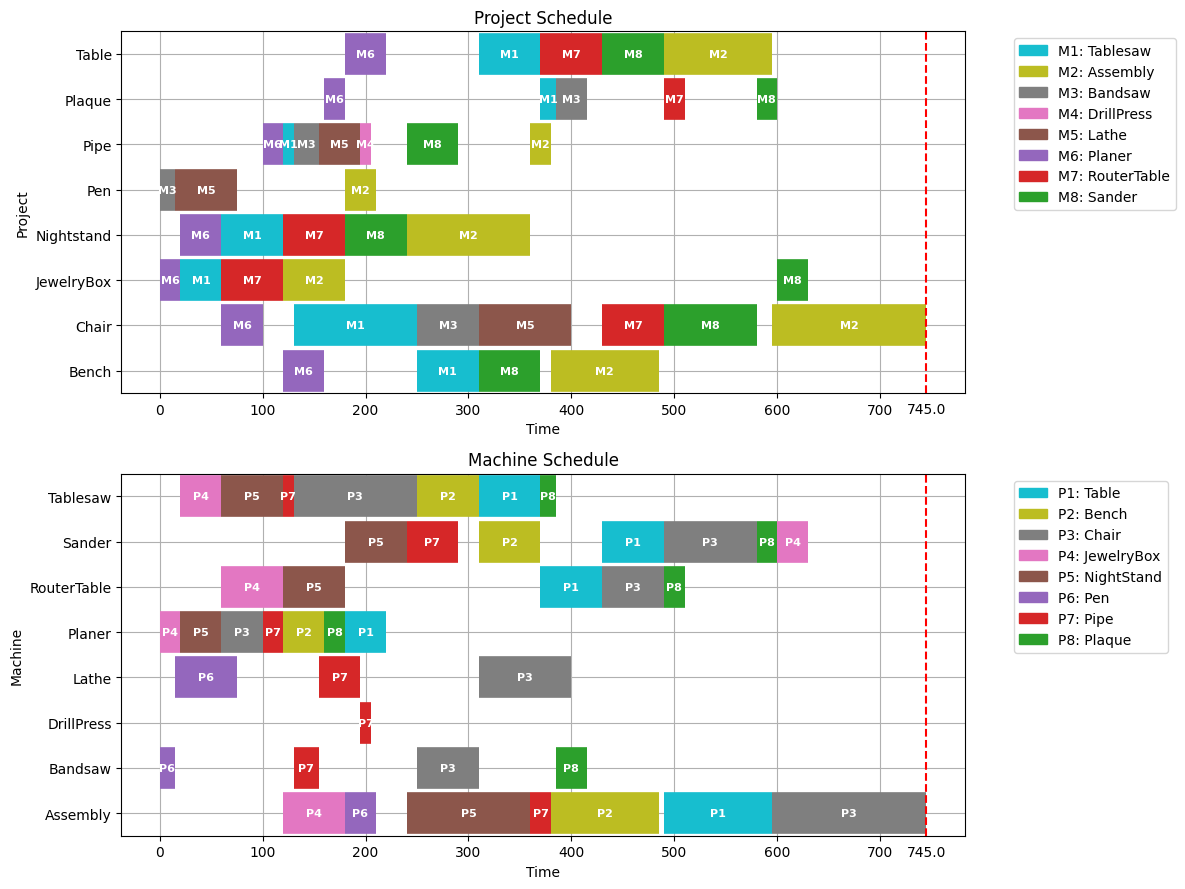

In [ ]:
def schedule_viz(results):
    #Extracting information from the results
    df_schedule = pd.DataFrame(results)
    projects = sorted(list(df_schedule['Project'].unique()))
    machines = sorted(list(df_schedule['Machine'].unique()))
    total_time = df_schedule['Finish'].max()

    #Setting the styles and colors for the viz
    text_style = {'color':'white', 'weight':'bold', 'ha':'center',
                  'va':'center', 'size':8, 'rotation':0}
    bar_style = {'alpha':1.0, 'lw':30, 'solid_capstyle':'butt'}
    colors = mpl.cm.tab10_r.colors

    #Sorting and indexing the schedule data for easier access
    df_schedule.sort_values(by=['Project', 'Start'], inplace=True)
    df_schedule.set_index(['Project', 'Machine'], inplace=True)

    #Creating the figure and axes for the viz
    fig, axes = plt.subplots(2, 1, figsize=(12, 5 + (len(projects) + len(machines))/4))

    #Creating dictionary for text in the viz
    machine_dict = {'Assembly': 'M2',
                    'Bandsaw': 'M3',
                    'DrillPress': 'M4',
                    'Lathe': 'M5',
                    'Planer': 'M6',
                    'RouterTable': 'M7',
                    'Sander': 'M8',
                    'Tablesaw': 'M1'}

    project_dict = {'Bench': 'P2',
                    'Chair': 'P3',
                    'JewelryBox': 'P4',
                    'Pen': 'P6',
                    'Pipe': 'P7',
                    'Plaque': 'P8',
                    'Nightstand': 'P5', 
                    'Table': 'P1'}

    #Iterating over each project and machine to plot the schedule
    for project_plot, project in enumerate(projects, 1):
        for machine_plot, machine in enumerate(machines, 1):
            if (project, machine) in df_schedule.index:
                start_time = df_schedule.loc[(project, machine), 'Start']
                finish_time = df_schedule.loc[(project, machine), 'Finish']
                
                #Assigning machine or project to the dic key to extract value
                machine_sub = machine_dict[machine]
                project_sub = project_dict[project]

                #Ploting the project schedule
                axes[0].plot([start_time, finish_time], [project_plot]*2, c=colors[machine_plot%8], **bar_style)
                axes[0].text((start_time + finish_time)/2, project_plot, machine_sub, **text_style)

                #Ploting the machine schedule
                axes[1].plot([start_time, finish_time], [machine_plot]*2, c=colors[project_plot%8], **bar_style)
                axes[1].text((start_time + finish_time)/2, machine_plot, project_sub, **text_style)

    # Creating the legend for the first plot using machine_dict
    machine_legend = []
    legend_names = ['M1: Tablesaw', 'M2: Assembly', 'M3: Bandsaw', 'M4: DrillPress', 'M5: Lathe', 'M6: Planer', 'M7: RouterTable', 'M8: Sander']
    for i, machine in enumerate(machines):
        machine_sub = machine_dict[machine]
        machine_legend.append(mpl.patches.Patch(color=colors[i%8], label=legend_names[i]))
    axes[0].legend(handles=machine_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

    #Creating the legend for the second plot using project_dict
    project_legend = []
    legend_names = ['P1: Table', 'P2: Bench', 'P3: Chair', 'P4: JewelryBox', 'P5: NightStand', 'P6: Pen', 'P7: Pipe', 'P8: Plaque']
    for i, project in enumerate(projects):
        project_sub = project_dict[project]
        project_legend.append(mpl.patches.Patch(color=colors[i%8], label=legend_names[i]))
    axes[1].legend(handles=project_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

    #Adding titles, labels, and other formatting to the viz
    axes[0].set_title('Project Schedule')
    axes[0].set_ylabel('Project')
    axes[1].set_title('Machine Schedule')
    axes[1].set_ylabel('Machine')

    for labels, i in enumerate([projects, machines]):
        axes[labels].set_ylim(0.5, len(i) + 0.5)
        axes[labels].set_yticks(range(1, 1 + len(i)))
        axes[labels].set_yticklabels(i)
        axes[labels].text(total_time, axes[labels].get_ylim()[0]-0.2, "{0:0.1f}".format(total_time), ha='center', va='top')
        axes[labels].plot([total_time]*2, axes[labels].get_ylim(), 'r--')
        axes[labels].set_xlabel('Time')
        axes[labels].grid(True)
    fig.tight_layout()

#Calling the function with the results data
schedule_viz(results)
